## 1. Load and preview the dataset

In [1]:
from datasets import load_dataset

dataset = load_dataset("ag_news")

/data/tianyang/anaconda3/envs/repobench/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset.keys()

dict_keys(['train', 'test'])

In [3]:
dataset["train"][0]

{'text': "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.",
 'label': 2}

In [4]:
dataset["test"][0]

{'text': "Fears for T N pension after talks Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul.",
 'label': 2}

In [5]:
# convert to pandas dataframe
import pandas as pd

train_df = pd.DataFrame(dataset["train"])
test_df = pd.DataFrame(dataset["test"])

# find the ones include #147; and print one
for i in range(len(train_df)):
    if "#147;" in train_df["text"][i]:
        print(i, train_df["text"][i])
        break
    
# find the ones include &it; and print one
for i in range(len(train_df)):
    if "&lt;" in train_df["text"][i]:
        print(i, train_df["text"][i])
        break

443 Technology as Fashion Analyzing the success of the iPod mini in Japan, JapanConsuming writes,  #147;The iPod mini is in fact one of those all too rare examples of an ideal product for the Japanese market. It is a product that does something useful, does it really well, and looks terrific too. None of these factors on their own is enough to make the iPod mini a success; their combination, through deft and creative implementation of function, is what makes the difference. Add in some tried and tested limited supply marketing, a store that looks as good as Louis Vuitton and a high impact award winning advertising campaign that has covered Tokyo in pink, green and yellow for weeks, and some of the reasons for the iPod mini phenomenon can be understood. #148; Aug 10
186 HP: The Adaptive Enterprise that can't adapt &lt;strong&gt;Opinion&lt;/strong&gt; SAP hardly to blame


## 2. Preprocess the data

### 2.1. Correct all the html tags

In [6]:
import html
import re

def correct_html(text):
    text = html.unescape(text)
    match = re.findall(r" #[A-Za-z0-9]+;", text)
    if match:  
        for m in match:
            text = text.replace(m, f"&{m[1:]}")
    
    text = html.unescape(text)
    return text

# apply the function to the text column
train_df["text"] = train_df["text"].apply(correct_html)
test_df["text"] = test_df["text"].apply(correct_html)
    
# check the 443 row in train_df
train_df["text"][443]

'Technology as Fashion Analyzing the success of the iPod mini in Japan, JapanConsuming writes, “The iPod mini is in fact one of those all too rare examples of an ideal product for the Japanese market. It is a product that does something useful, does it really well, and looks terrific too. None of these factors on their own is enough to make the iPod mini a success; their combination, through deft and creative implementation of function, is what makes the difference. Add in some tried and tested limited supply marketing, a store that looks as good as Louis Vuitton and a high impact award winning advertising campaign that has covered Tokyo in pink, green and yellow for weeks, and some of the reasons for the iPod mini phenomenon can be understood.” Aug 10'

### 2.2. Remove all the html code

In [7]:
def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

# apply the function to the text column
train_df["text"] = train_df["text"].apply(remove_html)
test_df["text"] = test_df["text"].apply(remove_html)

# check the 186 row in train_df
train_df["text"][186]

"HP: The Adaptive Enterprise that can't adapt Opinion SAP hardly to blame"

### 2.3 Remove all the urls

In [8]:
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

# apply the function to the text column
train_df["text"] = train_df["text"].apply(remove_urls)
test_df["text"] = test_df["text"].apply(remove_urls)

### 2.4 Solve some contractions

In [9]:
def solve_contractions(text):
    # Dictionary of contractions, abbreviations, and their expanded forms
    contractions = {
        # Currency symbols
        r"\b(\d+)\$": r"\1 dollars",           # Dollars
        r"\b(\d+)€": r"\1 euros",              # Euros
        r"\b(\d+)£": r"\1 pounds",             # Pounds
        r"\b(\d+)¥": r"\1 yen",                # Yen
        r"\b(\d+)₹": r"\1 rupees",             # Rupees
        r"\b(\d+)₩": r"\1 won",                # Won
        r"\b(\d+)₽": r"\1 rubles",             # Rubles
        r"\b(\d+)₣": r"\1 francs",             # Francs
    
        # Numerical abbreviations
        r"(\d+)000000000\b": r"\1 billion",    # Billions
        r"(\d+)000000\b": r"\1 million",       # Millions
        r"(\d+)000\b": r"\1 thousand",         # Thousands

        # Common contractions
        r"'ll\b": " will",                     # will
        r"'m\b": " am",                        # am
        r"'re\b": " are",                      # are
        r"'ve\b": " have",                     # have
        r"n't\b": " not",                      # not
        r"'d\b": " would",                     # would
        r"'s\b": " is",                        # is
        r"can't\b": "cannot",                  # cannot
        r"won't\b": "will not",                # will not
        r"don't\b": "do not",                  # do not
        r"ain't\b": "am not",                  # am not
        r"shan't\b": "shall not",              # shall not
        r"y'all\b": "you all",                 # you all
        r"ma'am\b": "madam",                   # madam
        r"o'clock\b": "of the clock",          # of the clock
        r"let's\b": "let us",                  # let us
        r"i'm\b": "I am",                      # I am
        r"she's\b": "she is",                  # she is
        r"he's\b": "he is",                    # he is
        r"it's\b": "it is",                    # it is
        r"that's\b": "that is",                # that is
        r"what's\b": "what is",                # what is
        r"where's\b": "where is",              # where is
        r"there's\b": "there is",              # there is
        r"who's\b": "who is",                  # who is
        r"how's\b": "how is",                  # how is
    }

    # Iterate over the contractions and replace them in text
    for contraction, replacement in contractions.items():
        text = re.sub(contraction, replacement, text, flags=re.IGNORECASE)

    return text

# apply the function to the text column
train_df["text"] = train_df["text"].apply(solve_contractions)
test_df["text"] = test_df["text"].apply(solve_contractions)

### 2.5 Removal and Lemmatization

In [10]:
# remove stopwords and punctuations
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
nltk.download("stopwords")

stop_words = set(stopwords.words("english"))

def remove_stopwords(text):
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word not in stop_words]
    return " ".join(filtered_text)

def remove_punctuations(text):
    punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    for punctuation in punctuations:
        text = text.replace(punctuation, "")
    return text

def remove_special_characters(text):
    text = re.sub(r"\W+", " ", text)
    return text

def remove_digits(text):
    text = re.sub(r"\d+", "", text)
    return text

def remove_extra_whitespace_tabs(text):
    text = re.sub(r"\s+", " ", text)
    return text.strip()

def remove_extra_words(text):
    words=['href','lt','gt','quot','com']
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word not in words]
    return " ".join(filtered_text)
    
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    word_tokens = word_tokenize(text)
    lemmatized_text = [lemmatizer.lemmatize(word) for word in word_tokens]
    return " ".join(lemmatized_text)

def normalize(text):
    text = text.lower()
    text = remove_stopwords(text)
    text = remove_punctuations(text)
    text = remove_digits(text)
    text = remove_extra_whitespace_tabs(text)
    text = remove_extra_words(text)
    text = lemmatize_text(text)
    return text

# apply the function to the text column
train_df["text"] = train_df["text"].apply(normalize)
test_df["text"] = test_df["text"].apply(normalize)

[nltk_data] Downloading package wordnet to /home/tianyang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/tianyang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
# let's sample several text in train_df
import random

random.seed(123)

for i in range(10):
    print(random.randint(0, len(train_df)), train_df["text"][i])

6863 wall st bear claw back black reuters reuters shortsellers wall street dwindlingband ultracynics seeing green
35084 carlyle look toward commercial aerospace reuters reuters private investment firm carlyle group which reputation making welltimed occasionallycontroversial play defense industry quietly placedits bet another part market
11427 oil economy cloud stock outlook reuters reuters soaring crude price plus worriesabout economy outlook earnings expected tohang stock market next week depth thesummer doldrums
100788 iraq halt oil export main southern pipeline reuters reuters authority halted oil exportflows main pipeline southern iraq afterintelligence showed rebel militia could strikeinfrastructure oil official said saturday
53377 oil price soar alltime record posing new menace u economy afp afp tearaway world oil price toppling record straining wallet present new economic menace barely three month u presidential election
34937 stock end near year low reuters reuters stock ended 

## 3. Save the preprocessed data

In [12]:
# export the dataframe to csv
import os

os.makedirs("data", exist_ok=True)

train_df.to_csv("data/train.csv", index=False)
test_df.to_csv("data/test.csv", index=False)

## 4. Visualize the data

In [13]:
# group the text by label
train_df.groupby("label").count()

,text
label,
0,30000
1,30000
2,30000
3,30000


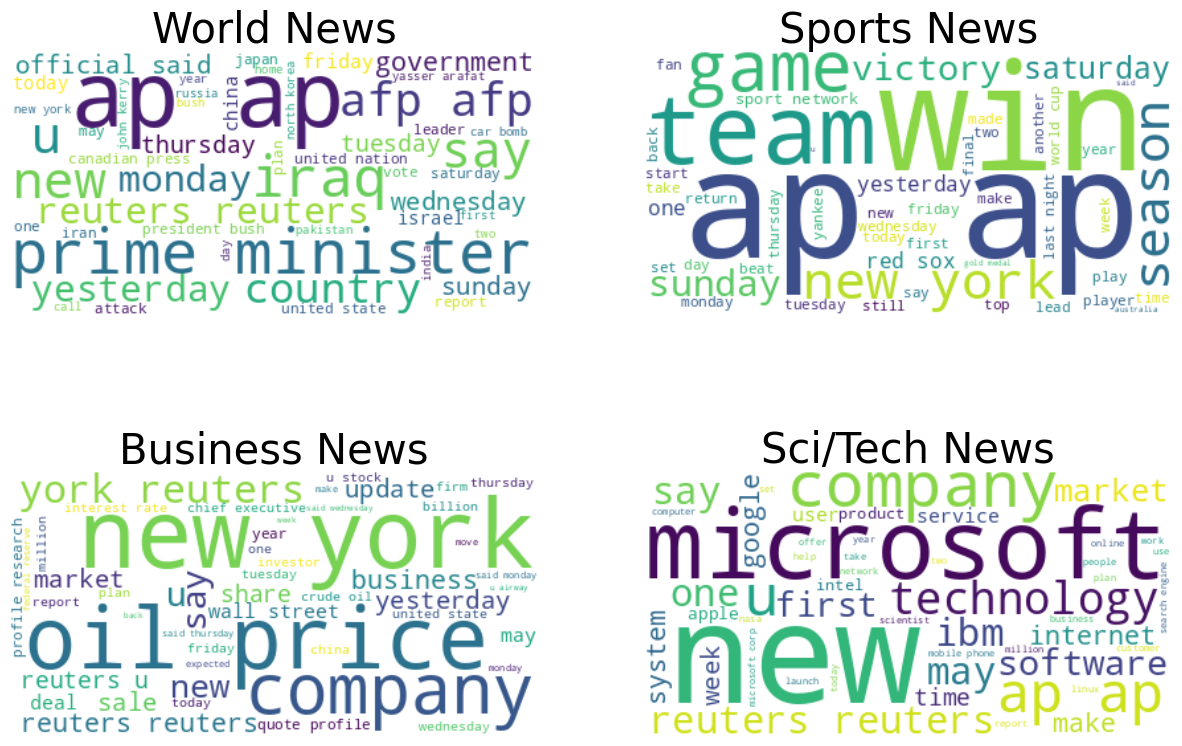

In [14]:
# use WordCloud to visualize the text
from wordcloud import WordCloud
from matplotlib import pyplot as plt

# Creating a word cloud for each topic
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flatten()

label_names = {0: 'World News', 1: 'Sports News', 2: 'Business News', 3: 'Sci/Tech News'}

for i in range(4):
    text = " ".join(train_df[train_df["label"] == i]["text"].tolist())
    cloud = WordCloud(background_color="white", max_words=50).generate(text)
    axs[i].imshow(cloud, interpolation='bilinear')
    axs[i].set_title(label_names[i], fontsize=30)
    axs[i].axis('off')

plt.show()